<img src='https://kabardewata.com/uploads/image/news_agustus/bumbu-bali-restaurant.jpg' style='width:100%; position:absolute;'>
<h1 style='text-align:center; font-size:100px; position:relative; opacity:0.9; padding-top:200px;'>THE BATTLE OF NEIGHBORHOODS</h1>

# INTRODUCTION: BUSINESS PROBLEM

IN THIS PROJECT, WE TRY TO FINDING SOLUTION FOR A CHEFF WHO WANT TO OPEN RESTAURANT
HE DONT KNOW WHICH PLACE THAT HAVE MOST STRATEGIC LOCATION, SO THE CHEF CONTACT US AS DATA SCIENTIST TO SOLVE HIS BUSINESS PROBLEM AND GET INSIGHT ABOUT LOCATION TO OPEN HIS RESTAURANT


# DATA

the data that we will use are:
<ol>
<li>number of worker and company in every regency by <a href='https://bali.bps.go.id/statictable/2019/10/09/161/jumlah-perusahaan-dan-tenaga-kerja-industri-besar-dan-sedang-menurut-kabupaten-kota-di-bali-2018.html'>Bali Statistics Agency</a></li>
<li>Regency list of bali from <a href='https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'>wikpedia</a></li>
<li><a href='https://developer.foursquare.com/'>Foursquare</a> API to find any recommended restaurant</li>
</ol>

data above will be crawling, understanding and cleaning to get insight about our business problem

In [548]:
#import module that used

from bs4 import BeautifulSoup   #for formatting web
import requests #for request web page
import pandas as pd #for data manipulation and analytic
from matplotlib import pyplot as plt #visualization
import re #for formatting
from geopy.geocoders import Nominatim   #for find coordinate
import folium   #for visualization
pd.set_option('display.max_columns', None)

# 1.1 EDA ON WIKIPEDIA DATA

In [549]:
#request web page then format it 
url = 'https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'
response    = requests.get(url)
soup    = BeautifulSoup(response.text, 'lxml')

In [550]:
#search table section

table   = soup.find('table')

In [551]:
#create empty list and iterate every row on table then append it to the list and create dataframe

regency = []
cgoverm = []
mayor   = []
area    = []
populat = []
subdist = []
village = []

for row in table.findAll('tr'):
    col = row.findAll('td')
    if len(col) == 10:
        regency.append(col[1].find(text=True))
        cgoverm.append(col[2].find(text=True))
        mayor.append(col[3].find(text=True))
        area.append(col[4].find(text=True).replace('\n',''))
        populat.append(col[5].find(text=True))
        subdist.append(col[6].find(text=True))
        village.append(col[7].find(text=True))        

dataframe   = { 'regency':regency,
                'central goverment':cgoverm,
                'mayor':mayor,
                'area (KM2)':area,
                'population (2017)':populat,
                'sub district':subdist,
                'village':village}

bali    = pd.DataFrame(dataframe)

In [552]:
#check dataframe
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,-,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [553]:
#change central goverment on kota denpasar

bali['central goverment'][8] = 'Denpasar'

In [554]:
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,Denpasar,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [555]:
#remove Kabupaten and Kota in dataframe & . on number column

bali['regency'] = bali['regency'].str.replace('Kabupaten','')
bali['regency'] = bali['regency'].str.replace('Kota','')

bali['area (KM2)'] = bali['area (KM2)'].str.replace('.','')
bali['area (KM2)'] = bali['area (KM2)'].apply(lambda x: re.match('[0-9]+',x).group())

bali['population (2017)'] = bali['population (2017)'].str.replace('.','')

bali['area (KM2)'] = bali['area (KM2)'].astype('int64')
bali['population (2017)'] = bali['population (2017)'].astype('int64')


In [556]:
#create new feature named density
bali['density (population / m2)'] = bali['population (2017)'] / (bali['area (KM2)']*1000)#convert km to m

#sort dataframe by density
bali.sort_values('density (population / m2)', ascending=False, inplace=True)

In [557]:
temp

,regency,large industry,li_Worker,medium industry,me_industry,total industry,total worker
8,Denpasar,21,7916,120,5039,141,12955
2,Badung,17,4467,44,1840,61,6307
3,Gianyar,9,1693,40,1627,49,3320
1,Tabanan,6,833,21,1076,27,1909
0,Jembrana,5,1901,18,704,23,2605
4,Klungkung,0,0,18,785,18,785
7,Buleleng,2,313,13,495,15,808
5,Bangli,2,276,5,145,7,421
6,Karangasem,0,0,7,364,7,364


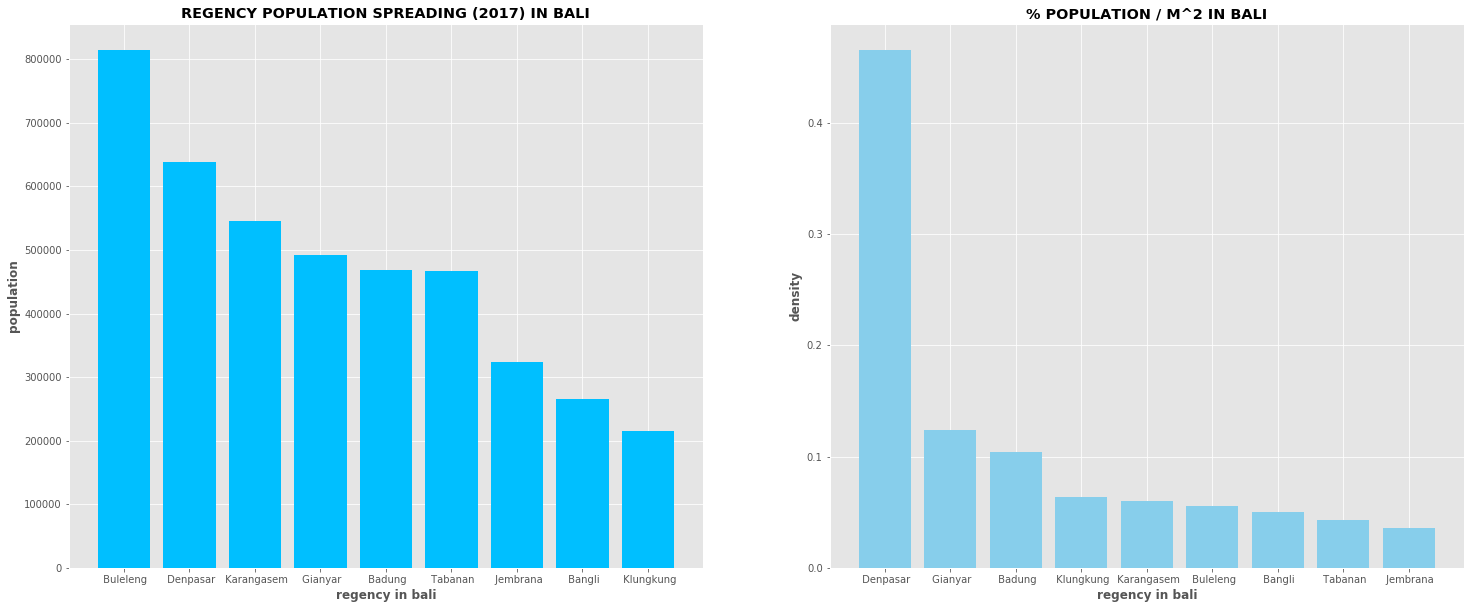

In [560]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize population
temp    = bali.sort_values('population (2017)', ascending=False)
ax[0].bar(temp['regency'], temp['population (2017)'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('population', fontweight='bold')
ax[0].set_title('REGENCY POPULATION SPREADING (2017) IN BALI', fontweight='bold')


#visualize density in regency
ax[1].bar(bali['regency'], (bali['density (population / m2)'] / sum(bali['density (population / m2)'])), color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('density', fontweight='bold')
ax[1].set_title('% POPULATION / M^2 IN BALI', fontweight='bold')


plt.show()

# 1.2 EDA ON WORKER DATA

In [561]:
#load worker dataset
worker  = pd.read_excel('data/pekerja.xlsx', skiprows=5)
worker

,Unnamed: 0,Establishment,Worker,Establishment.1,Worker.1,Establishment.2,Worker.2
0,Jembrana,5.0,1901.0,18.0,704.0,23.0,2605.0
1,Tabanan,6.0,833.0,21.0,1076.0,27.0,1909.0
2,Badung,17.0,4467.0,44.0,1840.0,61.0,6307.0
3,Gianyar,9.0,1693.0,40.0,1627.0,49.0,3320.0
4,Klungkung,0.0,0.0,18.0,785.0,18.0,785.0
5,Bangli,2.0,276.0,5.0,145.0,7.0,421.0
6,Karangasem,0.0,0.0,7.0,364.0,7.0,364.0
7,Buleleng,2.0,313.0,13.0,495.0,15.0,808.0
8,Denpasar,21.0,7916.0,120.0,5039.0,141.0,12955.0
9,Jumlah / Total :,62.0,17399.0,286.0,12075.0,348.0,29474.0


In [562]:
#rename column
worker.rename(columns= {'Unnamed: 0': 'regency', 
                        'Establishment': 'large industry', 'Worker':'li_Worker', 'Establishment.1': 'medium industry', 'Worker.1':'me_industry',
       'Establishment.2': 'total industry', 'Worker.2': 'total worker'}, inplace=True)

worker  = worker[0:9]

In [563]:
#change data type into integer
for i in worker.select_dtypes(include=['float64']):
    worker[i] = worker[i].astype('int64')

In [564]:
#sort dataframe from total worker value
worker.sort_values('total worker', ascending=False, inplace=True)

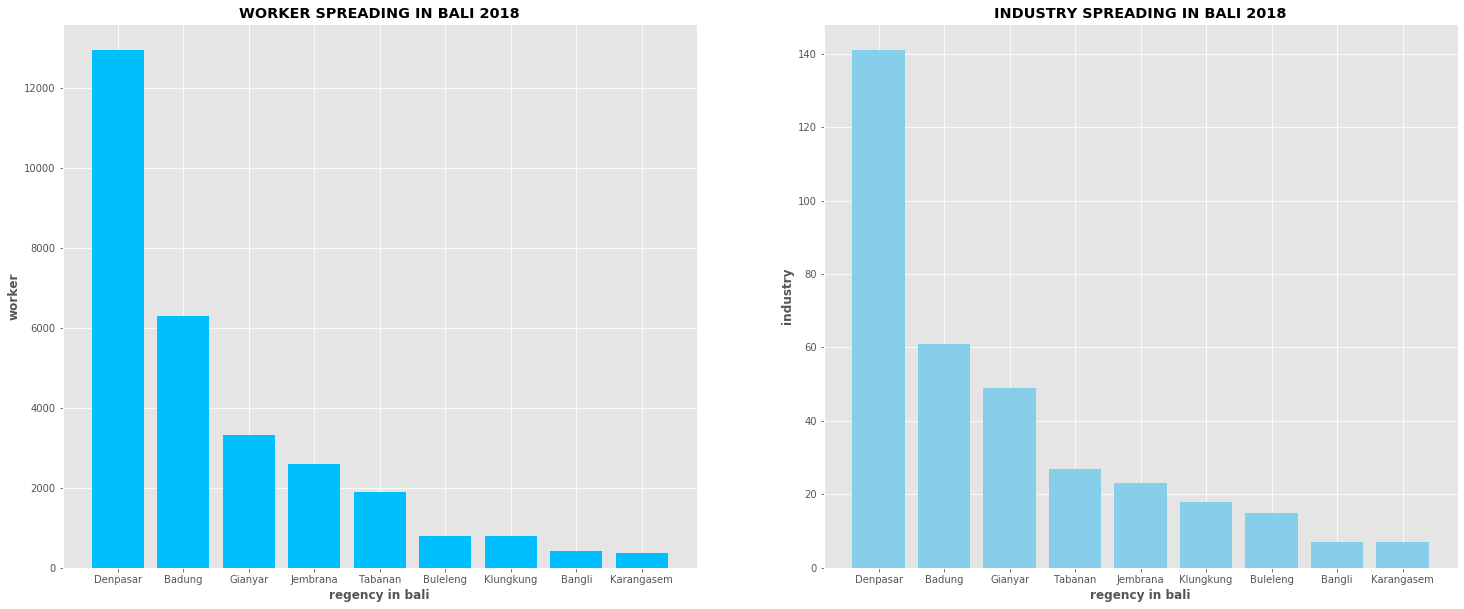

In [565]:
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize total worker
ax[0].bar(worker['regency'], worker['total worker'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('worker', fontweight='bold')
ax[0].set_title('WORKER SPREADING IN BALI 2018', fontweight='bold')

#visualize total industri
temp = worker.sort_values('total industry', ascending=False)
ax[1].bar(temp['regency'], temp['total industry'], color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('industry', fontweight='bold')
ax[1].set_title('INDUSTRY SPREADING IN BALI 2018', fontweight='bold')

plt.show()

NOW WE KNOW THAT DENPASAR IS THE MOST STRATEGIC REGENCY TO OPEN RESTAURANT, THE CONSIDERATION WE TAKE ARE DENSITY OF POPULATION AND INDUSTRY SPREADING IN REGENCY IS LEANING TO DENPASAR

In [566]:
#visualize denpasar map
geolocator   = Nominatim(user_agent='coursera_assignment')
location    = geolocator.geocode('Denpasar, Bali')

denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)
denpasar    

## LETS FIND OUT ANY RECOMMENDATION RESTAURANT IN DENPASAR

In [567]:
#input credential information about our api data

CLIENT_ID   = 'QMAJS1DGBLWIPIQAUKXZ1HSYANFW2HLRFQKBCF1HTN52V0L5'
CLIENT_SECRET   = 'RH5IXXL2L4CWSTAJMTTCFSPRA0DAA3IWM3DWUCEP243T2BXT'
VERSION = '20180323'
RADIUS  = 5000
LIMIT   = 250
PRICE   = '1,2'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [568]:
#set request into foursquare qpi (for get restaurant with price rating 1 to 2 / low to middle)
result  = requests.get(url).json()

In [569]:
#create function for filter categories
def get_category(row):
    try:
        category_list   = row['categories']
    
    except:
        category_list   = row['venue.categories']
    
    if len(category_list) == 0:
        return None
    
    else:
        return category_list[0]['name']

#create function for get restaurant label
def get_label(row):
    if (row.find('Restaurant') != -1) or (row.find('Café') != -1) or \
    (row.find('Fried') != -1) or (row.find('Coffee') != -1) or (row.find('Bar') != -1)\
    or (row.find('Bakery') != -1) or (row.find('Chips') != -1) or (row.find('Joint') != -1) \
    or (row.find('Food') != -1) or (row.find('Breakfast') != -1) or (row.find('Noodle') != -1)\
    or (row.find('Pizza') != -1):
        return 1

    else:
        return 0

In [570]:
#filter our data using function above
venues = result['response']['groups'][0]['items']
foursquare = pd.io.json.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
foursquare = foursquare.loc[:, filtered_columns]

foursquare['venue.categories'] = foursquare.apply(get_category, axis=1)
foursquare.columns = [col.split(".")[-1] for col in foursquare.columns]

foursquare['price'] = 'middle down'
foursquare['restaurant']    = foursquare['categories'].apply(get_label)
foursquare

,name,categories,lat,lng,price,restaurant
0,Kopi Bali Cap Kupu-Kupu Bola Dunia,Coffee Shop,-8.655491,115.213394,middle down,1
1,Warung Rujak Bisma,Salad Place,-8.650706,115.214355,middle down,0
2,Mitos Kopi,Coffee Shop,-8.653779,115.215148,middle down,1
3,Warung Pojok,Indonesian Restaurant,-8.640958,115.221910,middle down,1
4,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,middle down,1
...,...,...,...,...,...,...
95,Bakso Sapi Asli Riandy.M,Asian Restaurant,-8.673228,115.181895,middle down,1
96,Warung Liku,Indonesian Restaurant,-8.639346,115.254300,middle down,1
97,KFC / KFC Coffee,Fried Chicken Joint,-8.681884,115.191115,middle down,1
98,Kopi Made,Coffee Shop,-8.673133,115.230369,middle down,1


In [571]:
#change price range into 3,4
PRICE   = '3,4'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [572]:
#sent request into foursquare API (for get restaurant with price rating 1 to 2 / low to middle)
result  = requests.get(url).json()

In [573]:
#filtering data with our function
venues = result['response']['groups'][0]['items']
foursquare2 = pd.io.json.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
foursquare2 = foursquare2.loc[:, filtered_columns]

foursquare2['venue.categories'] = foursquare2.apply(get_category, axis=1)
foursquare2.columns = [col.split(".")[-1] for col in foursquare2.columns]

foursquare2['price'] = 'middle up'
foursquare2['restaurant']    = foursquare2['categories'].apply(get_label)
foursquare2

,name,categories,lat,lng,price,restaurant
0,Sushi Tsuki,Japanese Restaurant,-8.635960,115.219081,middle up,1
1,Gosha Kitchen & Patisserie,Steakhouse,-8.677157,115.228086,middle up,0
2,Warung Tahu Tek Khas Jakarta,American Restaurant,-8.628744,115.208742,middle up,1


In [574]:
#concate moddle up and middle down data
price   = pd.concat([foursquare, foursquare2])

In [581]:
#visualize  map with restaurant map
denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)

dmap = price[price['restaurant'] == 1]
for lat, lng, name, c in zip(dmap['lat'], dmap['lng'], dmap['name'],dmap['price']):
    if c == 'middle up':
        color = 'red'
    else:
        color = 'blue'
    
    label = folium.Popup(name, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#00bfff',
        fill_opacity=0.2,
        parse_html=False
        ).add_to(denpasar)

denpasar    

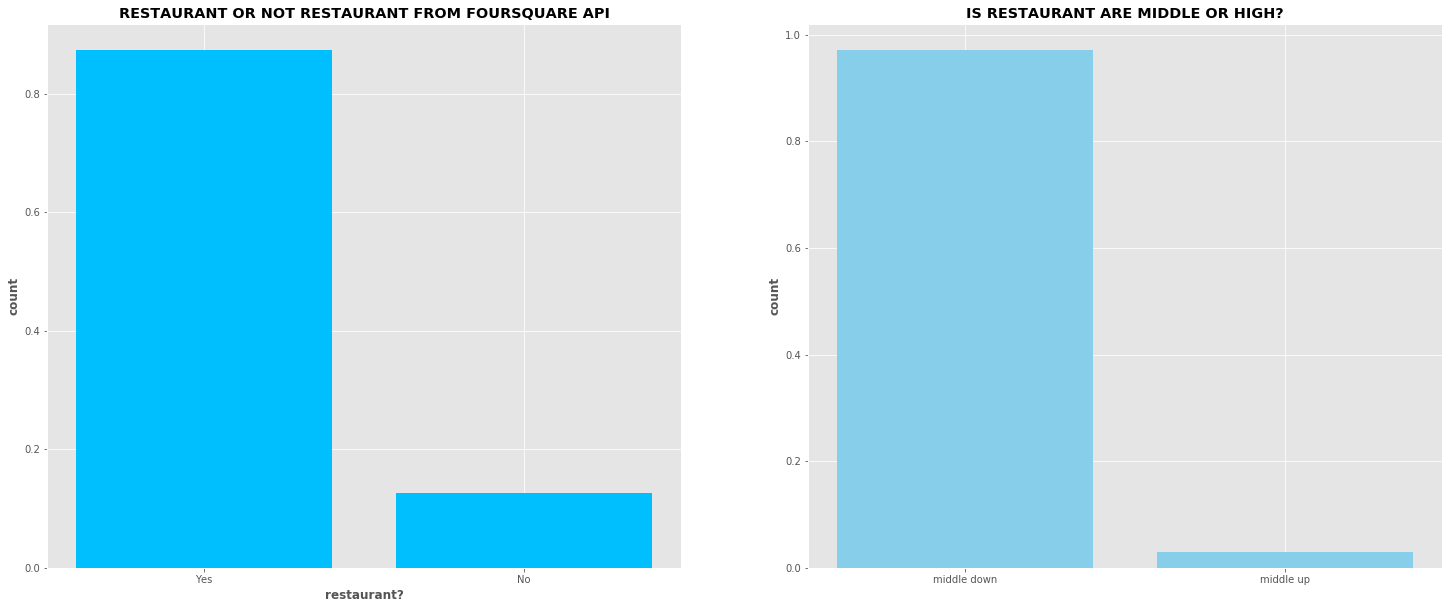

In [601]:
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize restaurant or not
ax[0].bar(['Yes','No'], (price['restaurant'].value_counts() / len(price['restaurant'])), color='deepskyblue')
ax[0].set_title('RESTAURANT OR NOT RESTAURANT FROM FOURSQUARE API', fontweight='bold')
ax[0].set_ylabel('count', fontweight='bold')
ax[0].set_xlabel('restaurant?', fontweight='bold')

#visualize is restaurant are middle or high
ax[1].bar(price['price'].value_counts().index, (price['price'].value_counts() / len(price['price'])), color='skyblue')
ax[1].set_title('IS RESTAURANT ARE MIDDLE OR HIGH?', fontweight='bold')
ax[1].set_ylabel('count', fontweight='bold')
plt.show()

# CONCLUSION
in the end, we get insight:
<ol>
<li>Denpasar is great place for opening restaurant because the population density and center of industry in bali</li>
<li>Restaurant in denpasar are mostly middle down, this will help our client to consider the food pricing</li>
</ol>